In [44]:
from typing import List, Tuple, Sequence

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_context("notebook", font_scale=1.)
sns.set_style("darkgrid")

In [45]:
def plot_ts(ts, title):
    """ Plot a time series. """
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(ts.index, ts, lw=2, label='NO2 concentration')
    ax.set_title(title, fontsize=30)
    ax.set_ylabel('{} values'.format(ts.name), fontsize=23)
    ax.set_xlabel('Timestamp', fontsize=23)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    fig.autofmt_xdate()

    return fig, ax


def plot_ma(ax, ts, ma_period):
    """ Plot a moving average for a time series in the given axes. """
    ma = ts.rolling(window=ma_period).mean()
    ax.plot(ts.index, ma, lw=1, label='{}-days MA'.format(ma_period))
    return ax


def plot_ts_ma(ts, ma_period, title):
    """ Plot a time series with its moving average given by the specified period. """
    fig, ax = plot_ts(ts, title)
    plot_ma(ax, ts, ma_period)
    ax.legend(fontsize=15)

    return fig, ax


def plot_ts_standard_mas(ts, title):
    """ Plot a time series with its moving average for 10, 20 and 50 days period. """
    ma_periods = [10, 25, 50]
    fig, ax = plot_ts(ts, title)
    for ma in ma_periods:
        plot_ma(ax, ts, ma)
    ax.legend(fontsize=15)

    return fig, ax


def plot_3d_clusters(data:np.array, y_kmeans:np.array):
    """ Plot clusters of data with 3 dimensions."""
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=y_kmeans, cmap='viridis')
    return fig, ax


def plot_ts_clusters_scatter(df, title):
    """ Plot clusters of data over time for NO2 pollutant measures. """
    clusters = df.groupby('y')
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    for name, c in clusters:
        ax.scatter(c.index, c['NO2'], label='Cluster {}'.format(name))

    ax.set_title(title, fontsize=30)
    ax.set_ylabel('NO2 values', fontsize=23)
    ax.set_xlabel('Timestamp', fontsize=23)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    ax.legend(fontsize=15)

    fig.autofmt_xdate()
    
    return fig, ax

In [46]:
def load_data(features:List) -> pd.DataFrame:
    """ Load the data set from the Huairou monitoring site and process
    it with a timestamp index, selecting the list of features passed as
    argument, upsampling to daily frequency measures and fillin the
    missing values with cubic interpolation. """
    
    print('Data: features={}'.format(features))
    df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')
    df.index = pd.to_datetime({'Year': df['Year'],
                                       'Month': df['Month'],
                                       'Day': df['Day'],
                                       'Hour': df['Hour']})
    return pd.DataFrame(
        data=df[features].values, 
        index=df.index, 
        columns=features, 
        dtype=np.float32
    ).sort_index().resample('D').mean().interpolate(method='cubic')


def scale_data(data: np.ndarray) -> np.ndarray:
    """ Interface for scaling a data set. In the current version,
    standard scaling is done with scikit-learn. """
    
    return StandardScaler().fit_transform(data)
    
    
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """ Interface for pre-processing the data.
    Add pre-processing steps here. """
    
    df.loc[:] = scale_data(data=df.values)
    print('Data after pre-processing:')
    print(df)
    return df


def create_fit_model(x: np.ndarray, init: str, n_clusters: int, n_init: int):
    """ Interface for creating and tRaining a model. In the current
    version, k-means is used with scikit-learn. """
    
    print('Model parameters: init={}, n_clusters={}, n_init={}'
          .format(init, n_clusters, n_init))
    model = KMeans(init=init, n_clusters=n_clusters, n_init=n_init)
    model.fit(x)
    return model

    
def evaluate_model(name: str, model, x: np.ndarray) -> List:
    """ Interface for evaluating a model. In the current version,
    a k-means model is evaluated with scikit-learn. Silhouette Coefficient
    and Calinski-Harabasz index are used as evaluation metrics. """
    
    silhouette = metrics.silhouette_score(x, model.labels_,metric='euclidean')
    calinski = metrics.calinski_harabasz_score(x, model.labels_)
    print('init\t\tnfeat\tclusters inertia silhouette calinski')
    print('%-9s\t%i\t%i\t%i\t%.3f\t%.3f'
          % (name, x.shape[1], model.cluster_centers_.shape[0],
             model.inertia_, silhouette, calinski))
    return [name, x.shape[1], model.cluster_centers_.shape[0],
            model.inertia_, silhouette, calinski]


def test(name: str = '_', features: List = ['NO2', 'Temp', 'WinSpeed'], n_clusters: int = 4,
         init: str = 'k-means++', n_init: int = 10) -> Tuple[List, pd.DataFrame]:
    """ Performs a test given the arguments and returns the model evaluation
    results alongside the data used with the cluster labels. Loads data,
    pre-process data, creates and fits a model and evaluates the model. """
    
    print(40 * '_' + name + 40 * '_')
    print('LOADING DATA')
    df = load_data(features=features)
    print('PRE-PROCESSING DATA')
    df = preprocess_data(df=df)
    print('MODELLING')
    model = create_fit_model(x=df.values, init=init, n_clusters=n_clusters, n_init=n_init)
    print('EVALUATING')
    res = evaluate_model(name=name, model=model, x=df.values)
    df['y'] = model.predict(df)
    return (res, df)


def experiment(tests: Tuple[str, List] = [('default',['NO2', 'Temp', 'WinSpeed'])],
               clusters: Sequence = range(3, 6)):
    """ Performs a grid search hyperparameter tuning for the features
    and clusters specified as arguments. """
    
    res_list = []
    data_list = []
    for name, features in tests:
        for c in clusters:
            res, data = test(features=features, n_clusters=c, name=name)
            res_list.append(res)
            data_list.append(data)
    results = pd.DataFrame(res_list, columns=['name', 'nfeat', 'clusters',
                                              'inertia', 'silhouette', 'calinski'])
    return results, data_list

In [47]:
# Testing the code with a default experiment. Click 'Output' to show logs.
results, data_list = experiment()
results

________________________________________default________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp  WinSpeed
2013-03-01 -0.991896 -1.142359  1.689868
2013-03-02  0.261877 -1.226816 -0.831676
2013-03-03  1.104497 -0.764858 -0.379230
2013-03-04 -0.270796 -0.362383  0.707429
2013-03-05  2.160248 -0.637901 -1.049502
...              ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.245105
2017-02-25 -0.846020 -0.600023  0.457004
2017-02-26 -0.006552 -0.625093 -0.183138
2017-02-27  0.999654 -0.534153 -0.290816
2017-02-28 -0.726563 -0.294041  0.547394

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
default  	3	3	1632	0.437	1227.812
________________________________________default________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp  WinSpeed
2013-03-01 -0.991896 -1.142359  1.689868
2013-03-02  0.261877 -1.226816 -0.831676
2013-03-03  1.104497 -0.764858 -0.379230
2013-03-04 -0.270796 -0.362383  0.707429
2013-03-05  2.160248 -0.637901 -1.049502
...              ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.245105
2017-02-25 -0.846020 -0.600023  0.457004
2017-02-26 -0.006552 -0.625093 -0.183138
2017-02-27  0.999654 -0.534153 -0.290816
2017-02-28 -0.726563 -0.294041  0.547394

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
default  	3	4	1290	0.390	1164.004
________________________________________default________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp  WinSpeed
2013-03-01 -0.991896 -1.142359  1.689868
2013-03-02  0.261877 -1.226816 -0.831676
2013-03-03  1.104497 -0.764858 -0.379230
2013-03-04 -0.270796 -0.362383  0.707429
2013-03-05  2.160248 -0.637901 -1.049502
...              ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.245105
2017-02-25 -0.846020 -0.600023  0.457004
2017-02-26 -0.006552 -0.625093 -0.183138
2017-02-27  0.999654 -0.534153 -0.290816
2017-02-28 -0.726563 -0.294041  0.547394

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
default  	3	5	1108	0.375	1075.654


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


,name,nfeat,clusters,inertia,silhouette,calinski
0,default,3,3,1632.889526,0.436796,1227.811821
1,default,3,4,1290.373901,0.390476,1164.003671
2,default,3,5,1108.200439,0.374971,1075.654274


In [48]:
tests = [('no2', ['NO2', 'Temp', 'WinSpeed']),
         ('with Press', ['NO2', 'Temp', 'Press', 'WinSpeed']),
         ('with DewP', ['NO2', 'Temp', 'DewP', 'WinSpeed']),
         ('with Rain', ['NO2', 'Temp', 'Rain', 'WinSpeed']),
         ('with Press DewP', ['NO2', 'Temp', 'Press', 'DewP', 'WinSpeed']),
         ('with Press Rain', ['NO2', 'Temp', 'Press', 'Rain', 'WinSpeed']),
         ('with DewP Rain', ['NO2', 'Temp', 'DewP', 'Rain', 'WinSpeed']),
         ('all', ['NO2', 'Temp', 'Press', 'DewP', 'Rain', 'WinSpeed'])]
clusters = range(2, 6)

# Click 'Output' to show logs.
results, data_list = experiment(tests=tests, clusters=clusters)

________________________________________no2________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp  WinSpeed
2013-03-01 -0.991896 -1.142359  1.689868
2013-03-02  0.261877 -1.226816 -0.831676
2013-03-03  1.104497 -0.764858 -0.379230
2013-03-04 -0.270796 -0.362383  0.707429
2013-03-05  2.160248 -0.637901 -1.049502
...              ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.245105
2017-02-25 -0.846020 -0.600023  0.457004
2017-02-26 -0.006552 -0.625093 -0.183138
2017-02-27  0.999654 -0.534153 -0.290816
2017-02-28 -0.726563 -0.294041  0.547394

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
no2      	3	2	2814	0.361	813.347
________________________________________no2________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp  WinSpeed
2013-03-01 -0.991896 -1.142359  1.689868
2013-03-02  0.261877 -1.226816 -0.831676
2013-03-03  1.104497 -0.764858 -0.379230
2013-03-04 -0.270796 -0.362383  0.707429
2013-03-05  2.160248 -0.637901 -1.049502
...              ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.245105
2017-02-25 -0.846020 -0.600023  0.457004
2017-02-26 -0.006552 -0.625093 -0.183138
2017-02-27  0.999654 -0.534153 -0.290816
2017-02-28 -0.726563 -0.294041  0.547394

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
no2      	3	3	1632	0.437	1227.812
________________________________________no2________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp  WinSpeed
2013-03-01 -0.991896 -1.142359  1.689868
2013-03-02  0.261877 -1.226816 -0.831676
2013-03-03  1.104497 -0.764858 -0.379230
2013-03-04 -0.270796 -0.362383  0.707429
2013-03-05  2.160248 -0.637901 -1.049502
...              ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.245105
2017-02-25 -0.846020 -0.600023  0.457004
2017-02-26 -0.006552 -0.625093 -0.183138
2017-02-27  0.999654 -0.534153 -0.290816
2017-02-28 -0.726563 -0.294041  0.547394

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
no2      	3	4	1290	0.390	1164.004
________________________________________no2________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp  WinSpeed
2013-03-01 -0.991896 -1.142359  1.689868
2013-03-02  0.261877 -1.226816 -0.831676
2013-03-03  1.104497 -0.764858 -0.379230
2013-03-04 -0.270796 -0.362383  0.707429
2013-03-05  2.160248 -0.637901 -1.049502
...              ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.245105
2017-02-25 -0.846020 -0.600023  0.457004
2017-02-26 -0.006552 -0.625093 -0.183138
2017-02-27  0.999654 -0.534153 -0.290816
2017-02-28 -0.726563 -0.294041  0.547394

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
no2      	3	5	1108	0.375	1075.671
________________________________________with Press________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'Press', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068  0.245105
2017-02-25 -0.846020 -0.600023  0.639554  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	2	3528	0.382	957.466
________________________________________with Press________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'Press', 'WinSpeed'

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068  0.245105
2017-02-25 -0.846020 -0.600023  0.639554  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	3	2245	0.421	1168.658
________________________________________with Press________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'Press', 'WinSpeed

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068  0.245105
2017-02-25 -0.846020 -0.600023  0.639554  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	4	1862	0.373	1038.060
________________________________________with Press________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'Press', 'WinSpeed

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068  0.245105
2017-02-25 -0.846020 -0.600023  0.639554  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	5	1597	0.309	967.368
________________________________________with DewP________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'DewP', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp      DewP  WinSpeed
2013-03-01 -0.991896 -1.142359 -1.675220  1.689868
2013-03-02  0.261877 -1.226816 -1.388242 -0.831676
2013-03-03  1.104497 -0.764858 -1.096097 -0.379230
2013-03-04 -0.270796 -0.362383 -1.129254  0.707429
2013-03-05  2.160248 -0.637901 -0.769715 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040 -1.024025  0.245105
2017-02-25 -0.846020 -0.600023 -0.967349  0.457004
2017-02-26 -0.006552 -0.625093 -0.776321 -0.183138
2017-02-27  0.999654 -0.534153 -0.709826 -0.290816
2017-02-28 -0.726563 -0.294041 -1.092421  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	2	3442	0.400	1017.657
________________________________________with DewP________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'DewP', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp      DewP  WinSpeed
2013-03-01 -0.991896 -1.142359 -1.675220  1.689868
2013-03-02  0.261877 -1.226816 -1.388242 -0.831676
2013-03-03  1.104497 -0.764858 -1.096097 -0.379230
2013-03-04 -0.270796 -0.362383 -1.129254  0.707429
2013-03-05  2.160248 -0.637901 -0.769715 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040 -1.024025  0.245105
2017-02-25 -0.846020 -0.600023 -0.967349  0.457004
2017-02-26 -0.006552 -0.625093 -0.776321 -0.183138
2017-02-27  0.999654 -0.534153 -0.709826 -0.290816
2017-02-28 -0.726563 -0.294041 -1.092421  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	3	2068	0.445	1330.698
________________________________________with DewP________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'DewP', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp      DewP  WinSpeed
2013-03-01 -0.991896 -1.142359 -1.675220  1.689868
2013-03-02  0.261877 -1.226816 -1.388242 -0.831676
2013-03-03  1.104497 -0.764858 -1.096097 -0.379230
2013-03-04 -0.270796 -0.362383 -1.129254  0.707429
2013-03-05  2.160248 -0.637901 -0.769715 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040 -1.024025  0.245105
2017-02-25 -0.846020 -0.600023 -0.967349  0.457004
2017-02-26 -0.006552 -0.625093 -0.776321 -0.183138
2017-02-27  0.999654 -0.534153 -0.709826 -0.290816
2017-02-28 -0.726563 -0.294041 -1.092421  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	4	1711	0.391	1173.163
________________________________________with DewP________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'DewP', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp      DewP  WinSpeed
2013-03-01 -0.991896 -1.142359 -1.675220  1.689868
2013-03-02  0.261877 -1.226816 -1.388242 -0.831676
2013-03-03  1.104497 -0.764858 -1.096097 -0.379230
2013-03-04 -0.270796 -0.362383 -1.129254  0.707429
2013-03-05  2.160248 -0.637901 -0.769715 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040 -1.024025  0.245105
2017-02-25 -0.846020 -0.600023 -0.967349  0.457004
2017-02-26 -0.006552 -0.625093 -0.776321 -0.183138
2017-02-27  0.999654 -0.534153 -0.709826 -0.290816
2017-02-28 -0.726563 -0.294041 -1.092421  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	5	1444	0.347	1108.488
________________________________________with Rain________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'Rain', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359 -0.212377  1.689868
2013-03-02  0.261877 -1.226816 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.212377 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041 -0.212377  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	2	4252	0.318	545.809
________________________________________with Rain________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'Rain', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359 -0.212377  1.689868
2013-03-02  0.261877 -1.226816 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.212377 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041 -0.212377  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	3	3044	0.391	670.143
________________________________________with Rain________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'Rain', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359 -0.212377  1.689868
2013-03-02  0.261877 -1.226816 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.212377 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041 -0.212377  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	4	2234	0.395	784.240
________________________________________with Rain________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'Rain', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359 -0.212377  1.689868
2013-03-02  0.261877 -1.226816 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.212377 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041 -0.212377  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	5	1891	0.336	760.758
________________________________________with Press DewP________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'Press', 'DewP'

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press      DewP  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879 -1.675220  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -1.388242 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -1.096097 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821 -1.129254  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -0.769715 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068 -1.024025  0.245105
2017-02-25 -0.846020 -0.600023  0.639554 -0.967349  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.776321 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.709826 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628 -1.092421  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	2	4028	0.412	1186.633
____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press      DewP  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879 -1.675220  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -1.388242 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -1.096097 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821 -1.129254  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -0.769715 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068 -1.024025  0.245105
2017-02-25 -0.846020 -0.600023  0.639554 -0.967349  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.776321 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.709826 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628 -1.092421  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	3	2683	0.420	1255.437
____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press      DewP  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879 -1.675220  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -1.388242 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -1.096097 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821 -1.129254  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -0.769715 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068 -1.024025  0.245105
2017-02-25 -0.846020 -0.600023  0.639554 -0.967349  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.776321 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.709826 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628 -1.092421  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	4	2298	0.324	1057.930
____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press      DewP  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879 -1.675220  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -1.388242 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -1.096097 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821 -1.129254  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -0.769715 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068 -1.024025  0.245105
2017-02-25 -0.846020 -0.600023  0.639554 -0.967349  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.776321 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.709826 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628 -1.092421  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	5	1945	0.303	1002.583


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with Press Rain________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'Press', 'Rain', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879 -0.212377  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023  0.639554 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press Rain	5	2	4946	0.355	695.594
_____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879 -0.212377  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023  0.639554 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press Rain	5	3	3653	0.383	728.470
_____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879 -0.212377  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023  0.639554 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press Rain	5	4	2844	0.388	761.688
_____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879 -0.212377  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023  0.639554 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press Rain	5	5	2464	0.335	714.868


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with DewP Rain________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'DewP', 'Rain', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp      DewP      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359 -1.675220 -0.212377  1.689868
2013-03-02  0.261877 -1.226816 -1.388242 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858 -1.096097 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383 -1.129254 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040 -1.024025 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023 -0.967349 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093 -0.776321 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153 -0.709826 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041 -1.092421 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	2	4854	0.371	736.576
______________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp      DewP      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359 -1.675220 -0.212377  1.689868
2013-03-02  0.261877 -1.226816 -1.388242 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858 -1.096097 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383 -1.129254 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040 -1.024025 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023 -0.967349 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093 -0.776321 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153 -0.709826 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041 -1.092421 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	3	3474	0.405	803.734


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with DewP Rain________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'DewP', 'Rain', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp      DewP      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359 -1.675220 -0.212377  1.689868
2013-03-02  0.261877 -1.226816 -1.388242 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858 -1.096097 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383 -1.129254 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040 -1.024025 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023 -0.967349 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093 -0.776321 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153 -0.709826 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041 -1.092421 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	4	2664	0.409	845.760
______________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp      DewP      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359 -1.675220 -0.212377  1.689868
2013-03-02  0.261877 -1.226816 -1.388242 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858 -1.096097 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383 -1.129254 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040 -1.024025 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023 -0.967349 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093 -0.776321 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153 -0.709826 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041 -1.092421 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	5	2255	0.405	815.099


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________all________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'Press', 'DewP', 'Rain', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press      DewP      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879 -1.675220 -0.212377  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -1.388242 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -1.096097 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821 -1.129254 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068 -1.024025 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023  0.639554 -0.967349 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.776321 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.709826 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628 -1.092421 -0.212377  0.547394

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press      DewP      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879 -1.675220 -0.212377  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -1.388242 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -1.096097 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821 -1.129254 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068 -1.024025 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023  0.639554 -0.967349 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.776321 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.709826 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628 -1.092421 -0.212377  0.547394

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press      DewP      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879 -1.675220 -0.212377  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -1.388242 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -1.096097 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821 -1.129254 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068 -1.024025 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023  0.639554 -0.967349 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.776321 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.709826 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628 -1.092421 -0.212377  0.547394

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________all________________________________________
LOADING DATA
Data: features=['NO2', 'Temp', 'Press', 'DewP', 'Rain', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2587963273.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                 NO2      Temp     Press      DewP      Rain  WinSpeed
2013-03-01 -0.991896 -1.142359  1.578879 -1.675220 -0.212377  1.689868
2013-03-02  0.261877 -1.226816  1.577173 -1.388242 -0.212377 -0.831676
2013-03-03  1.104497 -0.764858  0.345547 -1.096097 -0.212377 -0.379230
2013-03-04 -0.270796 -0.362383  0.649821 -1.129254 -0.212377  0.707429
2013-03-05  2.160248 -0.637901 -0.020205 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.248879 -0.800040  0.858068 -1.024025 -0.212377  0.245105
2017-02-25 -0.846020 -0.600023  0.639554 -0.967349 -0.212377  0.457004
2017-02-26 -0.006552 -0.625093  0.789199 -0.776321 -0.212377 -0.183138
2017-02-27  0.999654 -0.534153  0.473105 -0.709826 -0.212377 -0.290816
2017-02-28 -0.726563 -0.294041  0.253628 -1.092421 -0.212377  0.547394

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


{'whiskers': [<matplotlib.lines.Line2D at 0x2d3dd231cc0>,
 'caps': [<matplotlib.lines.Line2D at 0x2d3dd232200>,
 'boxes': [<matplotlib.lines.Line2D at 0x2d3dd231a20>],
 'medians': [<matplotlib.lines.Line2D at 0x2d3dd232740>],
 'fliers': [<matplotlib.lines.Line2D at 0x2d3dd2329e0>],
 'means': []}

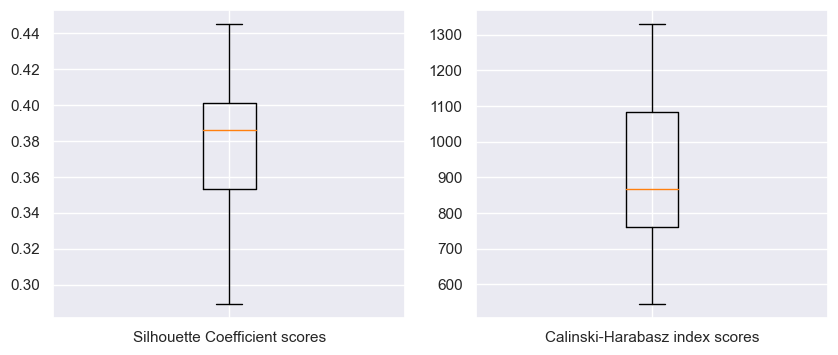

In [49]:
fig = plt.figure(figsize=(10, 4))
ax1, ax2 = fig.subplots(1, 2)
ax1.boxplot(results['silhouette'], labels=['Silhouette Coefficient scores'])
ax2.boxplot(results['calinski'], labels=['Calinski-Harabasz index scores'])

In [50]:
results.shape

(32, 6)

In [51]:
best_results = results.loc[(results['silhouette'] > 0.4) & (results['calinski'] > 1100)].sort_values(by='silhouette', ascending=False)
print(best_results)


               name  nfeat  clusters      inertia  silhouette     calinski
9         with DewP      4         3  2068.397705    0.445173  1330.698261
1               no2      3         3  1632.863403    0.436796  1227.811821
5        with Press      4         3  2245.017090    0.420629  1168.658269
17  with Press DewP      5         3  2683.553955    0.420147  1255.437205
16  with Press DewP      5         2  4028.523682    0.412024  1186.632638


C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2581613126.py:67: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2581613126.py:70: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2581613126.py:67: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2581613126.py:70: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_27816\2581613126.py:67: 

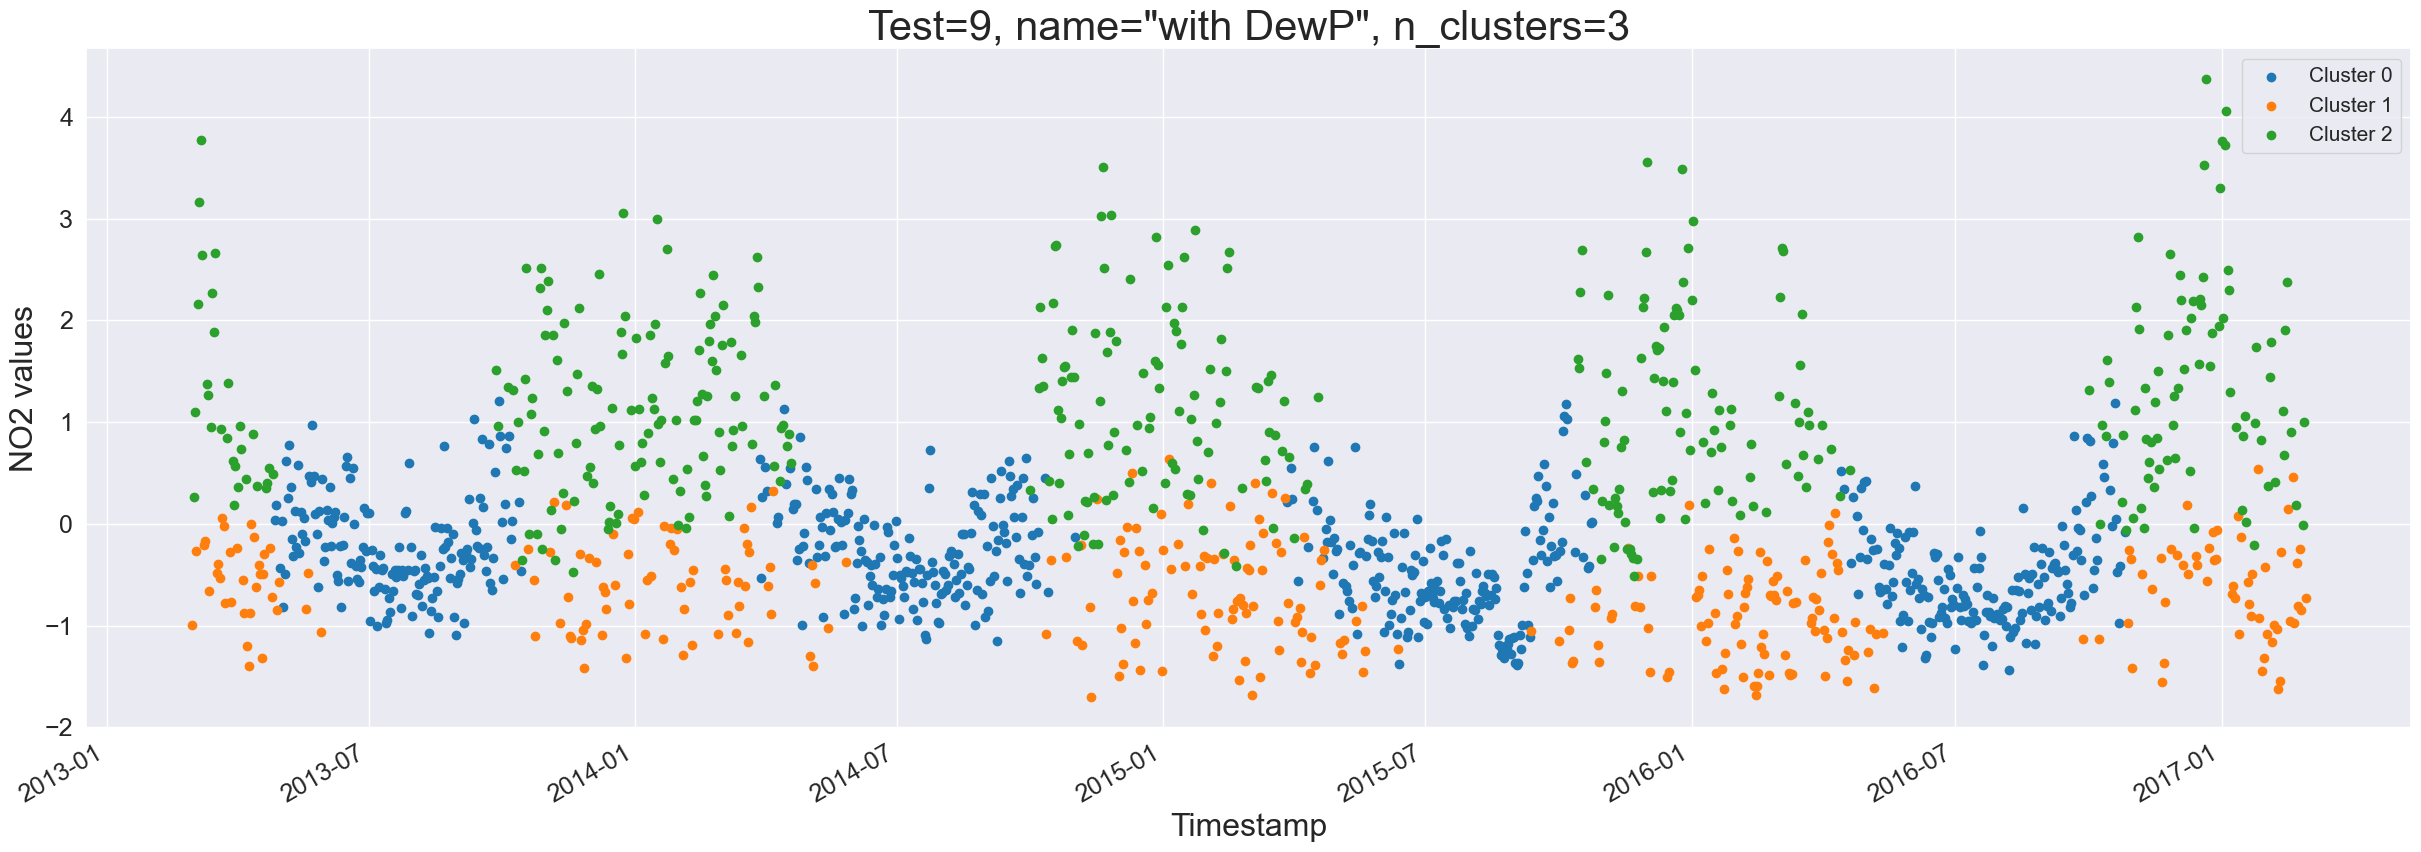

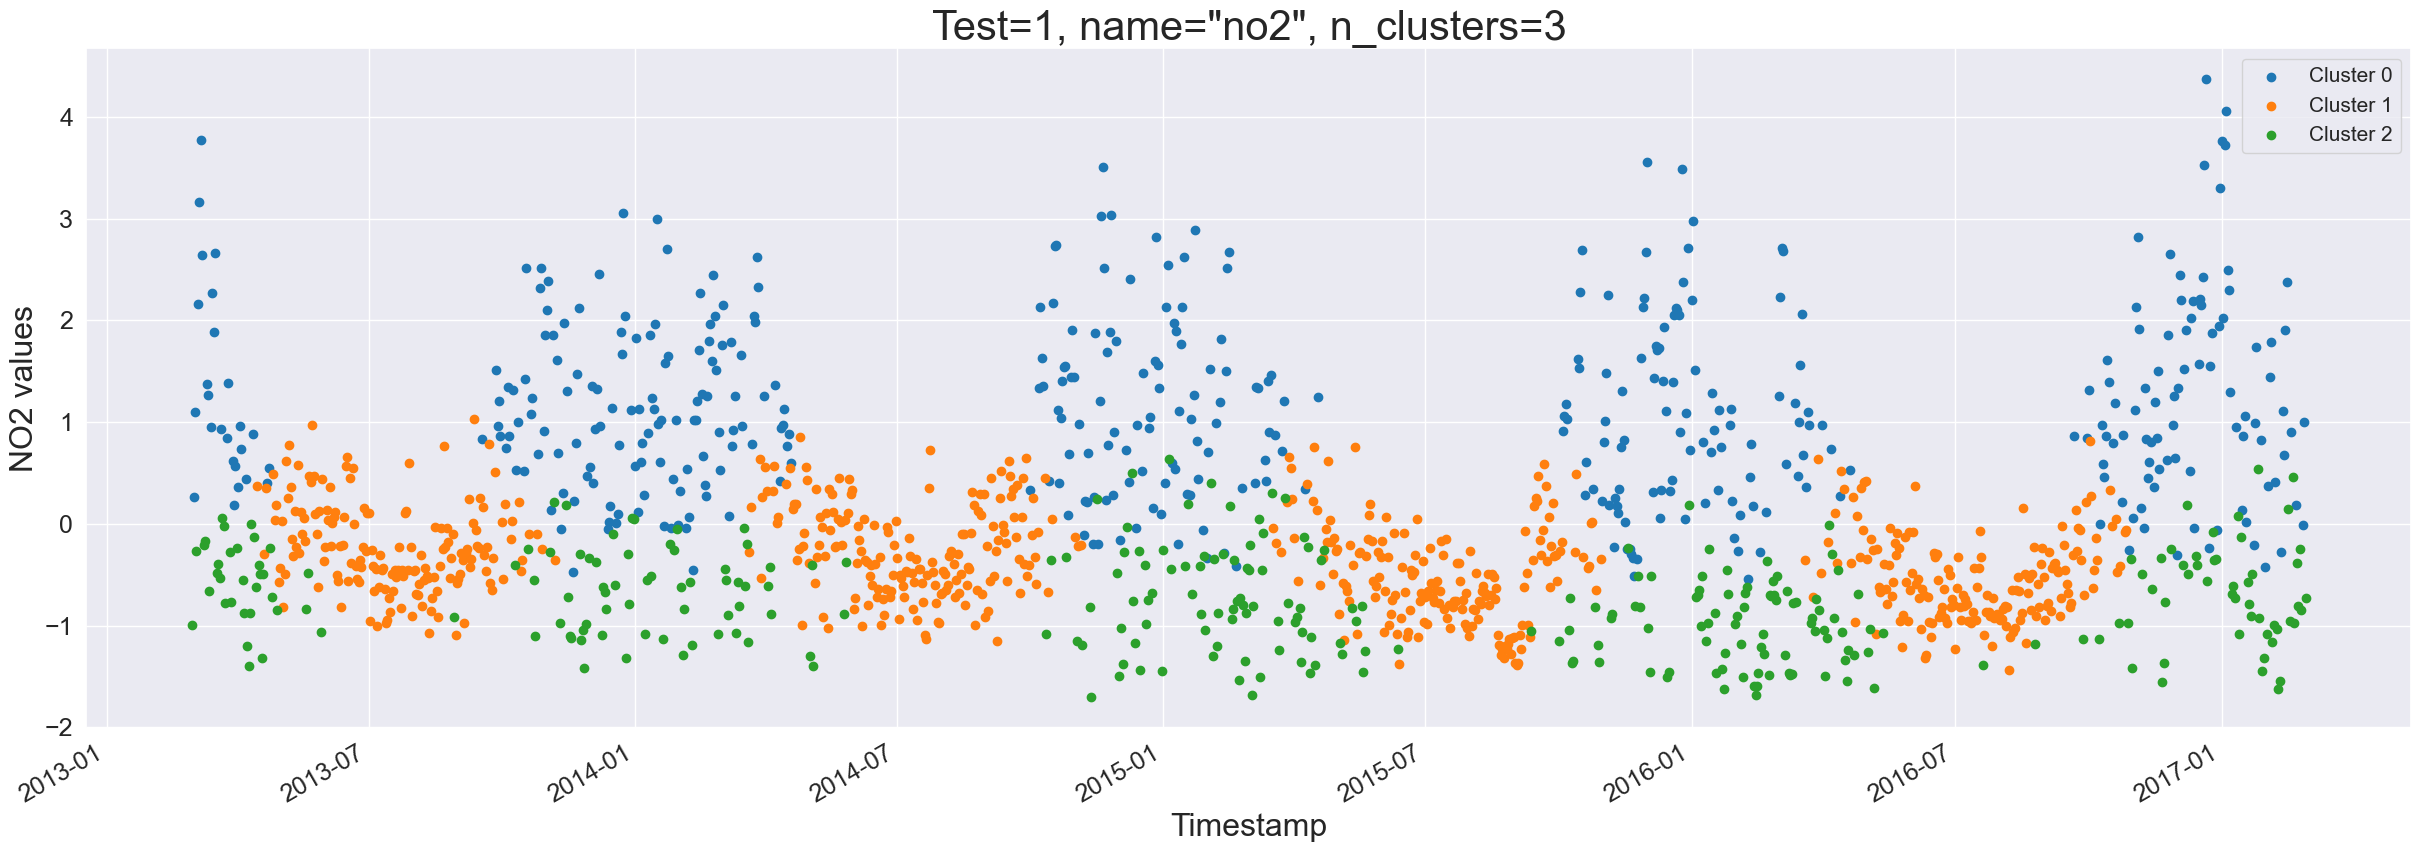

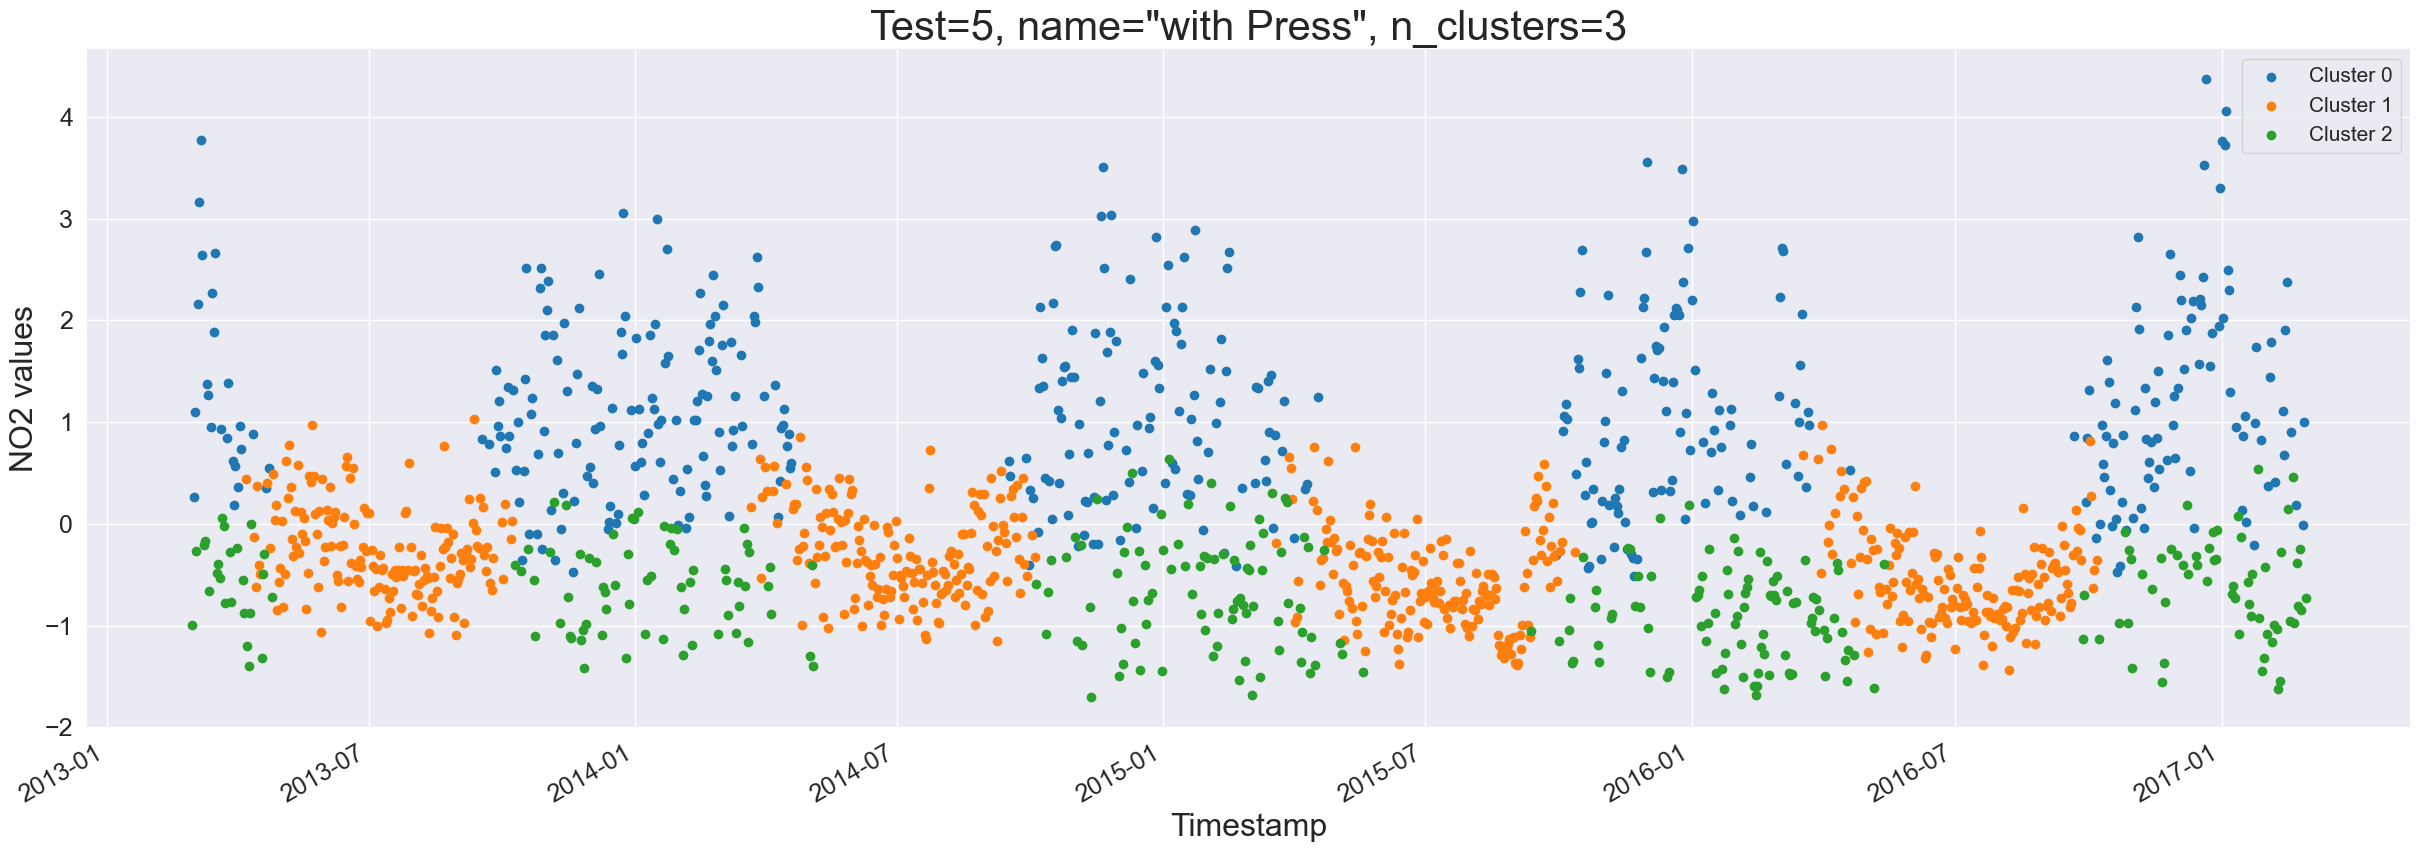

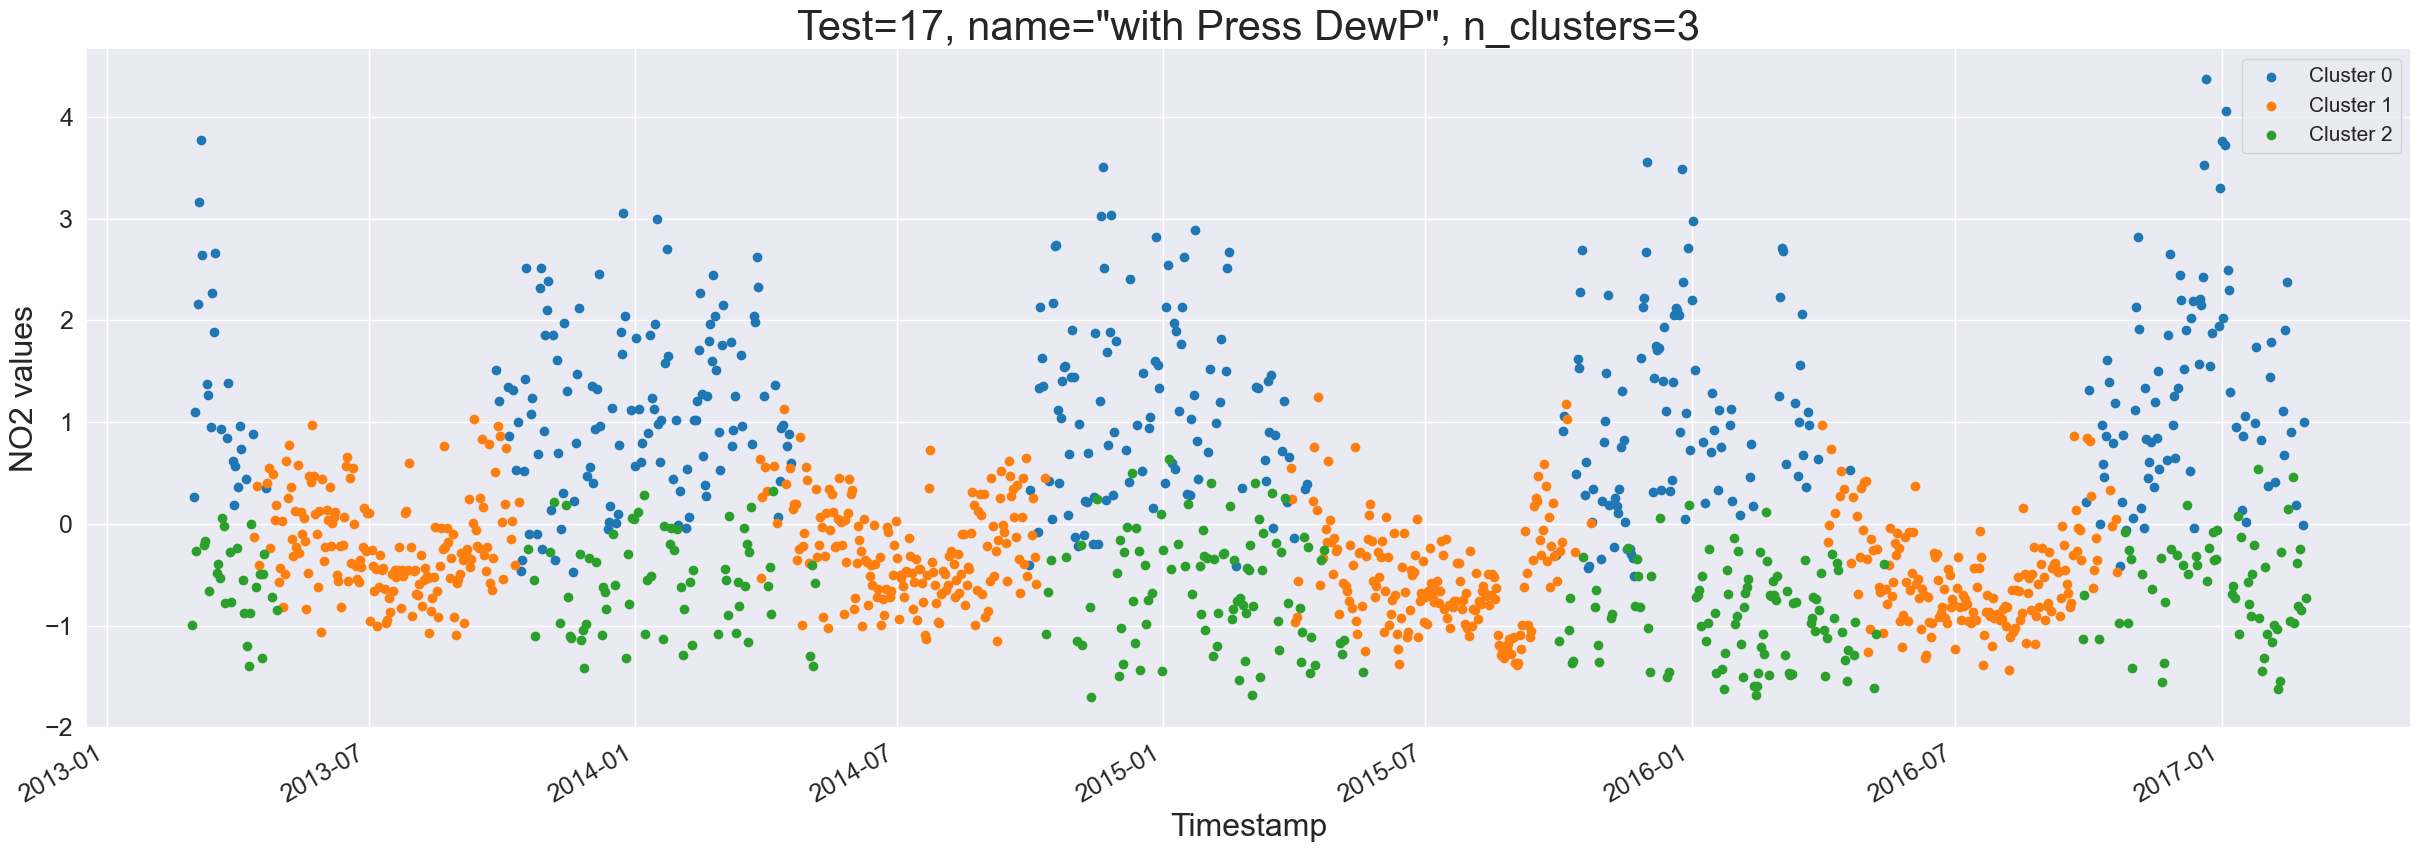

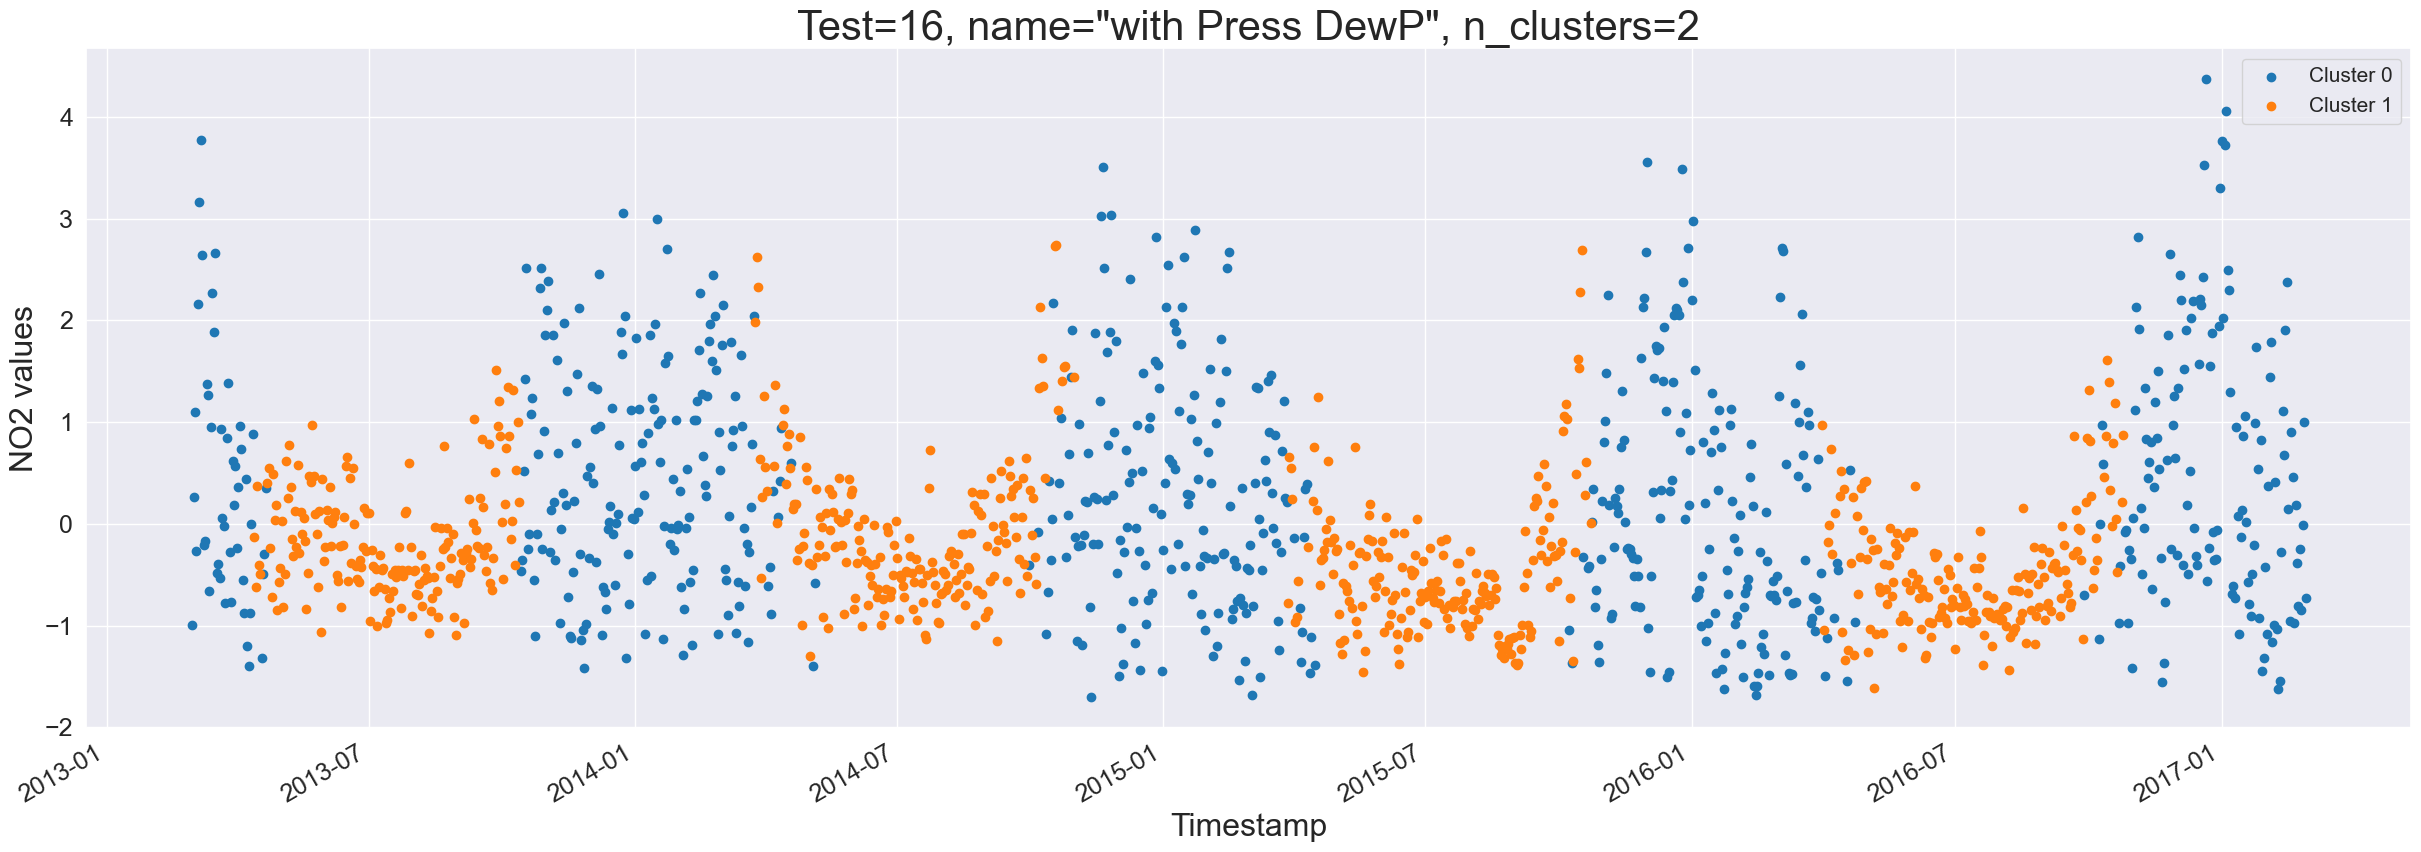

In [52]:
# Ploting clusters over the time series of the best models
for i in best_results.index:
    plot_ts_clusters_scatter(data_list[i], 'Test={}, name="{}", n_clusters={}'
                             .format(i, results.iloc[i, 0], results.iloc[i, 2]))